In [2]:
import json
import os
import glob
import re
import matplotlib.pyplot as plt
import pandas as pd
Mazarinade_path = "Corpus-main/Mazarinades_jsons/"  

### Test sur un seul dossier 1-100

Les fichiers qui contiennent que les vers sont sauvegardés dans un fichiers Json nommé 'sous_corpus_test.json'.

In [4]:
with open('sous_corpus_test.json', 'r') as ff:
    dossierTest = json.load(ff)
    ff.close()

### Préparation de la dictionnaire de référence

###préparons notre vocabualire issu du glaff
import re, json
import glob

with open("./glaff-1.2.2.txt", encoding="utf-8") as f:
  
  ligne = f.readline()
  cpt=0
  dic_glaff = {}
  while len(ligne)>0:
    #cpt+=1 #Nb des formes
    elems = re.split("\|", re.sub("\n", "", ligne)) # 17 
    forme = elems[0] #forme 
    phon = elems[4] #phonèmes
    fraRel = elems[8] #fréquence relative de lemma Frantext20e
    if phon != "" :#and float(fraRel) <  10 and  float(fraRel) > 5:
      cpt+=1 #Nb des formes
      dic_glaff[forme] = phon

    ligne = f.readline() # continu

with open("phon_glaff_%i.json"%cpt, "w") as w:
    w.write(json.dumps(dic_glaff,indent = 4, ensure_ascii = False)) #lisible pour l'humian

In [5]:
with open("phon_glaff_1406857.json", "r") as rr:
    rr = rr.read()
    dic_glaff = json.loads(rr) #lisible pour l'humian
    
set_mots_glaff = set(dic_glaff.keys())
print("Taille Glaff phonème : %i types"%len(set_mots_glaff))  # type(mot unique) VS token


Taille Glaff phonème : 937984 types


### Solution1 : Consultation de la dictionnaire pour compter les syllabes dans un mot

In [6]:
def compter_syllabes_glaff(phone):
    # Compter les syllabes dans un mot avec le glaff
    if ";" in phone:
        # plusieurs prononciations possibles, on prend la première
        phone = phone.split(";")[0]
    else :
        pass
    syllabes = phone.split(".") # chaque syllabe est séparée par un point
    return syllabes #len(syllabes)

### Solution2 : Phonétisation et Comptage des syllabes avec ```kevin lenzo text-to-phone conversion``` basé sur l'arbre de décision 

Les scripts sont disponibles dans le dossier Lenzo. Pour cet algorithme, une fois que l'arbre de décision est construit à partir d'un dictionnaire alignée, il permet de phonétiser les tokens avec des régles apprises. Les données d'entraînement viennent des tokens ayant la fréquence 5 < fraRel <  10 dans la GLAFF.

In [7]:
import subprocess

def phonetiseur_lenzo(word):
    process = subprocess.Popen(['perl', './Lenzo/t2p_dt.pl'], 
                               stdin=subprocess.PIPE, 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.PIPE, 
                               text=True)

    # transmettre le mot à phonétiser et fermer le processus
    output, error = process.communicate(input=word)
    
    if process.returncode == 0:
        return  output.strip()
    else:
        raise Exception(f"Erreur en phonétisant le mot: {error}")
# test
phonetique = phonetiseur_lenzo("Raconter le succés de nos ressouissances.")
phonetique


'R a k _ O~ t e _ l @ s y k s _ _ _ _ d _ n o _ R @ _ s w _ i s _ _ A~ _ _ _ _'

### Combinaison des deux solutions pour obtenir le nombre de syllabes dans un vers

In [8]:
def est_octosyllabe_glaff(ligne):
    voyelles = ["i","e","E","a","A","o","O","u","y","2","9","@","e~","a~","o~","9~","O~","A~",'v']
    ligne = re.sub("ſ", "s", ligne)
    ligne = re.sub("&amp;", "", ligne)
    ligne = re.sub(r"\d", "", ligne)
    ligne = re.sub(r",", "", ligne)
    ligne = re.sub(r";", "", ligne)
    ligne = re.sub(r"\.", "", ligne)
    if ligne.isupper() == True :
        ligne = ""
    mots = ligne.split()
    mots_lower = []
    for mot in mots :
        if mot.isalpha() == True and len(mot) == 1:
           mots_lower.append(mot.lower())
        elif mot.isupper() == False:
            mots_lower.append(mot.lower())

    NbSyllabes = 0
    phonetique = []
    for mot in mots_lower:
        if mot in dic_glaff.keys() and dic_glaff[mot] != "":
            NbSyllabes += len(compter_syllabes_glaff(dic_glaff[mot]))
            indice =  compter_syllabes_glaff(dic_glaff[mot])
        else:
            indice = phonetiseur_lenzo(mot)
            for phone in phonetiseur_lenzo(mot).split(" "):
                if phone in voyelles:
                    NbSyllabes += 1
        phonetique.append(indice)
    if NbSyllabes != 0:
        return NbSyllabes, phonetique
    else:
        pass


In [10]:
resultatsM = {}
for fichier in dossierTest:
    resultatsM[fichier] = {"MoyenneSyllabe": 0, "NB_vers": 0}
    Nb_vers = 0
    somme_syllabes = 0
    for vers in dossierTest[fichier][0]:
        
        if est_octosyllabe_glaff(vers) != None :
            nombre_syllabes_ph,phonetique = est_octosyllabe_glaff(vers)
            if  nombre_syllabes_ph > 4 and nombre_syllabes_ph < 13:
                #print(nombre_syllabes_ph,"  ",vers)
                #print("      ",phonetique)
                Nb_vers += 1
                somme_syllabes += nombre_syllabes_ph
    
    resultatsM[fichier]["MoyenneSyllabe"] = somme_syllabes/Nb_vers
    resultatsM[fichier]["NB_vers"] = Nb_vers
    print(fichier, somme_syllabes/Nb_vers, Nb_vers)
    

1-100/Moreau50_GALL 7.170454545454546 176
1-100/Moreau100_GALL 7.218543046357616 151
1-100/Moreau65_GALL 7.333333333333333 321
1-100/Moreau56_GALL 7.378973105134475 818
1-100/Moreau21_GALL 7.4147727272727275 176
1-100/Moreau42_MAZ 7.375 88
1-100/Moreau45_GALL 7.517006802721088 147
1-100/Moreau13_GALL 7.454545454545454 99
1-100/Moreau37_GBOOKS 7.1911764705882355 68
1-100/Moreau5_GALL 10.557142857142857 70
1-100/Moreau20_GALL 7.462068965517242 145
1-100/Moreau93_GALL 8.622857142857143 175
1-100/Moreau40_GALL 7.248995983935743 249
1-100/Moreau61_GALL 8.57638888888889 144
1-100/Moreau84_GALL 7.477611940298507 201
1-100/Moreau53_GALL 7.338842975206612 242
1-100/Moreau55_GALL 7.371478873239437 568
1-100/Moreau74_GALL 7.125 128
1-100/Moreau91_GALL 7.376506024096385 332
1-100/Moreau36_GALL 7.247787610619469 226


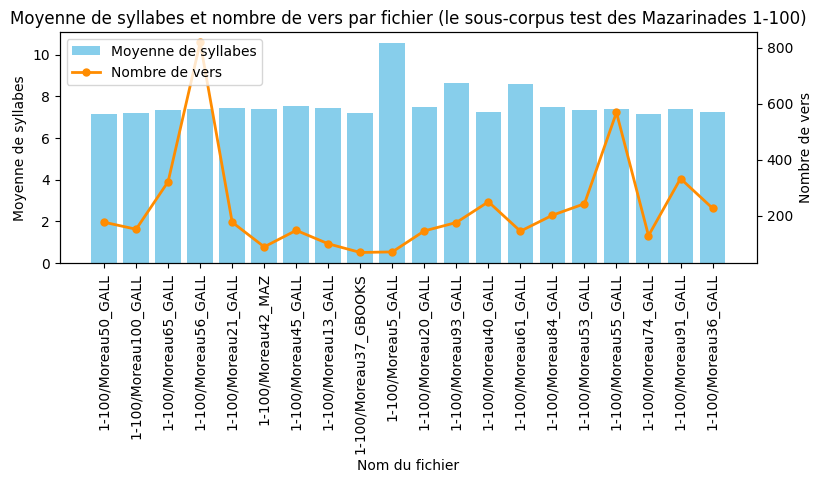

In [11]:
# 转换字典为DataFrame
df_m = pd.DataFrame(resultatsM).T.reset_index()
df_m.columns = ['Nom du fichier', 'Moyenne de syllabes', 'Nombre de vers']

fig, ax1 = plt.subplots(figsize=(9, 3))


color = 'skyblue'
ax1.set_xlabel('Nom du fichier')
ax1.set_ylabel('Moyenne de syllabes')
bars = ax1.bar(df_m['Nom du fichier'], df_m['Moyenne de syllabes'], color=color, label='Moyenne de syllabes')
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', labelrotation=90)

ax1.set_title('Moyenne de syllabes et nombre de vers par fichier (le sous-corpus test des Mazarinades 1-100)')

ax2 = ax1.twinx()
color = 'darkorange'
ax2.set_ylabel('Nombre de vers')
line = ax2.plot(df_m['Nom du fichier'], df_m['Nombre de vers'], color=color, marker='o', linestyle='-', linewidth=2, markersize=5, label='Nombre de vers')
ax2.tick_params(axis='y')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()



### Retouner à la lecture des fichiers

In [86]:
Nb_vers = 0
somme_syllabes = 0
for vers in dossierTest["1-100/Moreau5_GALL"][0]:
        
        if est_octosyllabe_glaff(vers) != None :
            nombre_syllabes_ph,phonetique = est_octosyllabe_glaff(vers)
            if  nombre_syllabes_ph > 4 and nombre_syllabes_ph < 13:
                print(nombre_syllabes_ph,"  ",vers)
                print("      ",phonetique)
                #print("-------------------")
                Nb_vers += 1
                somme_syllabes += nombre_syllabes_ph
print( somme_syllabes/Nb_vers, Nb_vers)

11    ILluſtre Senateur, Hero Icomparable,
       [['i', 'lystR'], 's @ n a t _ 9 R', '_ @ R o', 'i k O~ _ p a R a b l _']
11    Qu’on ne m’aceuſe pas te croyant Adorable
       ['k _ _ _ _ j O~', ['n@'], 'm _ _ _ a s _ 2 z _', ['pA'], ['t@'], ['kRwa', 'jA~'], ['a', 'dO', 'Rabl']]
11    Si i’eſeue dta gloire vn ſi fameux Autel
       [['si'], 'i _ _ _ @ z _ _ _', 'd t a', ['glwaR'], 'v _', ['si'], ['fa', 'm2'], ['o', 'tEl']]
12    Quel honnbur dans ce lieux ne doit-on point te rendre
       [['kEl'], '_ O n _ b y R', ['dA~'], ['s@'], ['lj2'], ['n@'], 'd w _ a _ j O~', ['pwE~'], ['t@'], ['RA~dR']]
12    Dans les ſiecles paſſez vit-on iamais mortel,
       [['dA~'], ['le'], ['sjEkl'], ['pa', 'se'], 'v i _ _ j O~', 'j a m _ E _', ['mOR', 'tEl']]
10    Nylebruit des priſons, des tourmens, ny des chaiſnes,
       ['n i l _ b R H i _', ['de'], ['pRi', 'zO~'], ['de'], 't _ u R m _ E~ _', 'n i', ['de'], '_ S _ E _ _ _ _']
11    Ny l’horreur des bourreaux, ny de leurs dures genés,
       ['n i